In [18]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from nnAudio.Spectrogram import CQT1992v2
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import cv2
sys.path.insert(0, "../")

In [2]:
from gwpy.timeseries import TimeSeries   
import matplotlib.pyplot as plt
import cv2
from joblib import Parallel, delayed

%matplotlib inline 

In [3]:
from src.transforms import minmax_bandpass_transform,  min_max_scale

In [4]:
INPUT_PATH = Path("/home/trytolose/rinat/kaggle/grav_waves_detection/input")

In [5]:
# df = pd.read_csv(INPUT_PATH / "training_labels.csv")
df = pd.read_csv("OOF_pred_turkey_bandpass.csv")
files = list((INPUT_PATH / "train").rglob("*.npy"))
FILE_PATH_DICT = {x.stem: str(x) for x in files}
df["path"] = df["id"].apply(lambda x: FILE_PATH_DICT[x])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
df["fold"] = -1
for f, (train_ids, val_ids) in enumerate(skf.split(df.index, y=df["target"])):
    df.loc[val_ids, "fold"] = f

In [6]:
xx = df[df['target']==1].sort_values("pred", ascending=True).reset_index(drop=True)
xx

,id,target,fold,pred,path
0,70063e8730,1,0,0.052103,/home/trytolose/rinat/kaggle/grav_waves_detect...
1,443cb4e726,1,4,0.059609,/home/trytolose/rinat/kaggle/grav_waves_detect...
2,fb04b05218,1,1,0.059739,/home/trytolose/rinat/kaggle/grav_waves_detect...
3,29841b8674,1,3,0.060090,/home/trytolose/rinat/kaggle/grav_waves_detect...
4,eb9ab6e655,1,4,0.060275,/home/trytolose/rinat/kaggle/grav_waves_detect...
...,...,...,...,...,...
279925,8c99006b5b,1,0,1.000000,/home/trytolose/rinat/kaggle/grav_waves_detect...
279926,8c8b75fa89,1,2,1.000000,/home/trytolose/rinat/kaggle/grav_waves_detect...
279927,9ff46febce,1,3,1.000000,/home/trytolose/rinat/kaggle/grav_waves_detect...
279928,8cb0dbadac,1,4,1.000000,/home/trytolose/rinat/kaggle/grav_waves_detect...


In [7]:
df.shape

(560000, 5)

In [8]:
class CFG:
    def __init__(self):
        self.qtransform_params = {
            'sr': 2048,
            'fmin': 20,
            'fmax': 1024,
            'hop_length': 8,
            'bins_per_octave': 48,
            'filter_scale': 0.5,
        }

        self.bandpass_param = {
          'lf': 30,
          'hf': 800,
          'order': 8, 
          'sr': 2048,
        }
cfg = CFG()

In [9]:
cqt = CQT1992v2(**cfg.qtransform_params)

CQT kernels created, time used = 0.0626 seconds


/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


In [10]:
TOTAL_MAX_VAL = np.array([4.16750054e-20, 4.16596419e-20, 1.11610637e-20])
TOTAL_MIN_VAL = np.array([-4.42943562e-20, -4.23039083e-20, -1.08631992e-20])

def min_max_scale(waves, min_val=-1, max_val=1):
    X_std = (waves.T - TOTAL_MIN_VAL) / (TOTAL_MAX_VAL - TOTAL_MIN_VAL)
    print(X_std.max(axis=0), X_std.min(axis=0))
    X_scaled = X_std * (max_val - min_val) + min_val
    return X_scaled.T

In [11]:
x = np.load(df.loc[0, "path"])
print(x.min(axis=1))
x.max(axis=1)
min_max_scale(x, -1, 1).max()

[-1.28118802e-20 -1.67240769e-20 -3.89266180e-21]
[0.67507423 0.70694507 0.70269435] [0.36620577 0.304654   0.31649356]


0.4138901350191193

In [12]:
df

,id,target,fold,pred,path
0,00000e74ad,1,0,0.938779,/home/trytolose/rinat/kaggle/grav_waves_detect...
1,00001f4945,0,0,0.626251,/home/trytolose/rinat/kaggle/grav_waves_detect...
2,0000a38978,1,0,0.815851,/home/trytolose/rinat/kaggle/grav_waves_detect...
3,0000bb9f3e,1,0,0.909749,/home/trytolose/rinat/kaggle/grav_waves_detect...
4,0000d61b7b,1,0,0.762802,/home/trytolose/rinat/kaggle/grav_waves_detect...
...,...,...,...,...,...
559995,fffe76e415,1,0,0.671611,/home/trytolose/rinat/kaggle/grav_waves_detect...
559996,fffe81f2ec,0,2,0.201075,/home/trytolose/rinat/kaggle/grav_waves_detect...
559997,fffef24633,1,2,0.734050,/home/trytolose/rinat/kaggle/grav_waves_detect...
559998,ffff5c861a,0,4,0.935525,/home/trytolose/rinat/kaggle/grav_waves_detect...


torch.Size([3, 1, 4096])


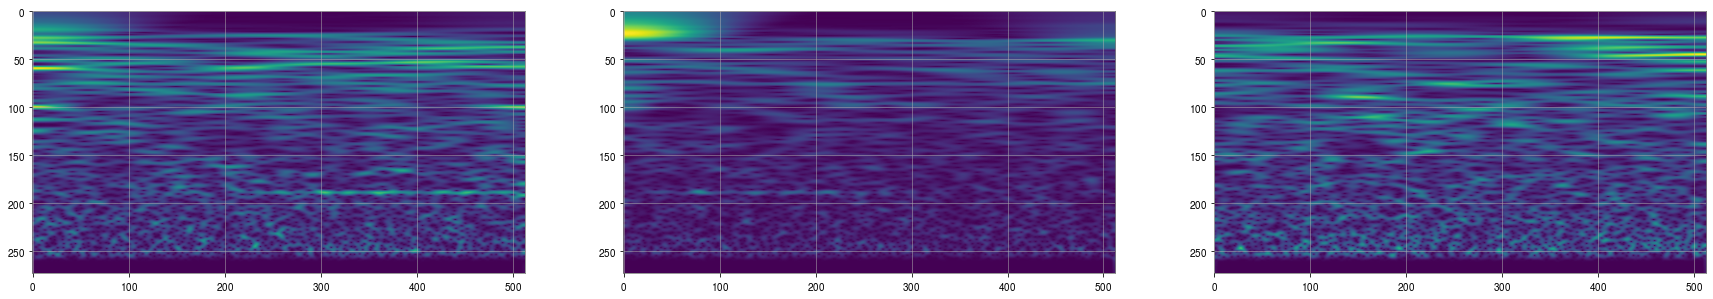

In [17]:
x = np.load(df.loc[231342, "path"])

x = minmax_bandpass_transform(x, lf=30, hf=800)
x = torch.tensor(x).float().unsqueeze(1)
print(x.shape)
out = cqt(x)
# out = torch.absolute(out).squeeze().cpu().numpy()

plt.figure(figsize=(30, 30))
plt.subplot(131)
plt.imshow(out[0])
plt.subplot(132)
plt.imshow(out[1])
plt.subplot(133)
plt.imshow(out[2])
plt.show()

# plt.imshow(
#     out[0],
#     aspect="auto",
#     vmax=out.max(),
#     vmin=out.min(),
# )

torch.Size([3, 4096])


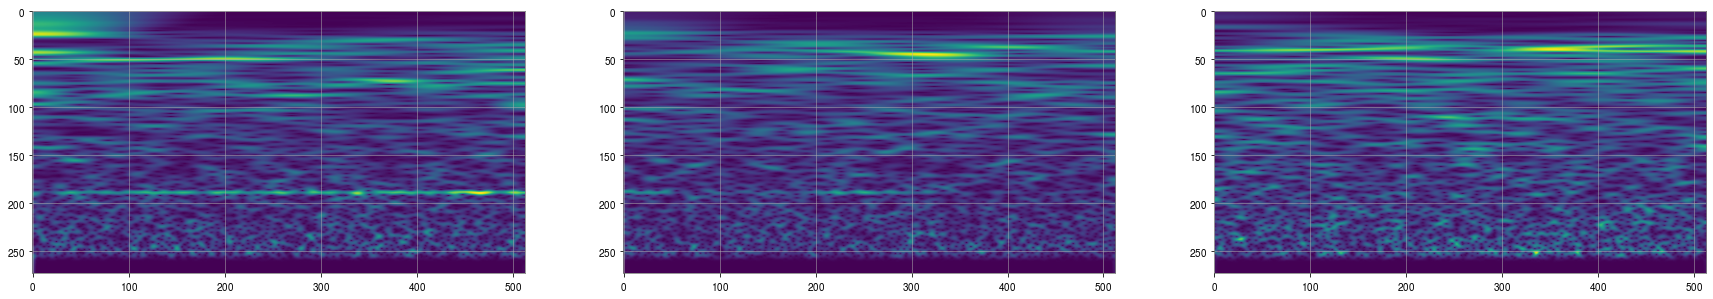

In [119]:
x = np.load(df.loc[33, "path"])

x = minmax_bandpass_transform(x, cfg.bandpass_param)
x = torch.tensor(x).float()#.unsqueeze(0)
print(x.shape)
out = cqt(x)
# out = torch.absolute(out).squeeze().cpu().numpy()

plt.figure(figsize=(30, 30))
plt.subplot(131)
plt.imshow(out[0])
plt.subplot(132)
plt.imshow(out[1])
plt.subplot(133)
plt.imshow(out[2])
plt.show()

# plt.imshow(
#     out[0],
#     aspect="auto",
#     vmax=out.max(),
#     vmin=out.min(),
# )

In [37]:
out.shape

(3, 45, 1025)

In [ ]:
from scipy import signal
def stack_bandpass_turkey_transform(waves, params):
#     waves = waves / np.max(waves)
#     waves = apply_win(waves)
    waves = apply_bandpass(waves, **params)
    # waves = np.hstack(waves)
    return waves

def apply_bandpass(x, lf=30, hf=400, order=8, sr=2048):
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    return signal.sosfiltfilt(sos, x) / normalization
def apply_win(x):
    xr = x*signal.tukey(4096, 0.1)
    return xr

In [ ]:
# for _, row in df[(df['target']==1) & (df['pred']<0.2)].sample(30, replace=False, random_state=1).iterrows():
for _, row in df[(df['target']==0) & (df['pred']>.9)].sample(40, replace=False, random_state=1).iterrows():
    
    x = np.load(row["path"])
    x = stack_bandpass_turkey_transform(x, cfg.bandpass_param)
    x = cqt(torch.tensor(x).float())
    
    x = x.squeeze().numpy()
    print(x.mean(axis=(1,2)))
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.title(f"target: {row['target']} pred: {row['pred']}")
    plt.imshow(x[0])
    plt.subplot(132)
    plt.imshow(x[1])
    plt.subplot(133)
    plt.imshow(x[2])
    
    plt.show()
    break

In [ ]:
[0.00930675 0.00949222 0.01424521]
[0.01025635 0.01018105 0.01501465]

[2.5128476e-22 2.4947712e-22 3.6827268e-22]

In [ ]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
data = np.load("../input/train/0/0/0/000a5b6e5c.npy")

d1 = TimeSeries(data[2,:], sample_rate=2048)

In [ ]:
hq = d1.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
fig4 = hq.plot(figsize=[12, 10])
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Time [s]');

In [ ]:
hq = d1.q_transform(qrange=(16,32), frange=(20,600), logf=False, whiten=False)
fig4 = hq.plot(figsize=[12, 10])
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Time [s]');

In [ ]:
np.array(hq).shape

In [ ]:
tt.shape

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(tt)

In [ ]:
from scipy import signal

TOTAL_MAX_VAL = np.array([4.61521162e-20, 4.16596419e-20, 1.11610637e-20])
TOTAL_MIN_VAL = np.array([-4.42943562e-20, -4.23039083e-20, -1.08631992e-20])


def apply_bandpass(x, lf=30, hf=400, order=8, sr=2048):
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    return signal.sosfiltfilt(sos, x) / normalization


def min_max_scale(waves, min_val=-1, max_val=1):
    X_std = (waves.T - TOTAL_MIN_VAL) / (TOTAL_MAX_VAL - TOTAL_MIN_VAL)
    X_scaled = X_std * (max_val - min_val) + min_val
    return X_scaled.T

def create_cqt(wave):
    d1 = TimeSeries(wave, sample_rate=2048)
    hq = d1.q_transform(qrange=(16,32), frange=(20,600), logf=False, whiten=False)
    return np.array(hq)

def get_cqt_image(path):
    waves = np.load(path)
#     waves = min_max_scale(waves)
#     waves = apply_bandpass(waves)
    
    img = np.stack([create_cqt(w) for w in waves], axis=2)
    return img

In [ ]:
img = get_cqt_image("../input/train/0/0/0/000a5b6e5c.npy")

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,1])
plt.show()

In [ ]:
df

In [ ]:
df[df['fold']==0]

In [ ]:
for f in range(5):
    df_f = df[df['fold']==f].reset_index(drop=True)
    scaled_fp16 = []
    for i in tqdm(range(df_f.shape[0])):
        wave_scaled = min_max_scale(np.load(df.loc[i, 'path'])).astype(np.float16)
        scaled_fp16.append(wave_scaled)
    scaled_fp16 = np.stack(scaled_fp16)
    np.save(f"../input/fp16/train/fold_{f}.npy", scaled_fp16)

In [ ]:
for f in range(5):
    df_f = df[df['fold']==f].reset_index(drop=True)
    target = df_f["target"].values.astype(np.int8)
    np.save(f"../input/fp16/train/fold_{f}_target.npy", target)

In [ ]:
!ls -lh ../input/fp16/train/

In [ ]:
from src.dataset import InMemoryDataset
from torch.utils.data import DataLoader

In [ ]:
ds = InMemoryDataset("../input/fp16/train", [0,1,2,3])

In [ ]:
xx = [0, 1, 2, 3, 4]

xx.remove(3)

In [ ]:
xx.remove(1)

In [ ]:
xx

In [5]:


def gwpy_qtransform(file_path, save_path, img_size=(256, 256)):
    x = np.load(file_path)
    x = min_max_scale(x)
    images = []
    for ii in range(3):
        strain = TimeSeries(x[ii,:],t0=0,  dt=1/2048)

        hq = strain.q_transform(qrange=(4, 32), frange=(20, 400), logf=False, whiten=True, fduration=1,
                               tres = 2/1000)
        images.append(hq)
        
    img = np.stack([np.array(x).T[:-200] for x in images], axis=2)
    img = cv2.resize(img, img_size).astype(np.float16)
    file_save_path = Path(save_path) / Path(file_path).name
    np.save(file_save_path, img)
#     return img

In [6]:
Parallel(n_jobs=16)(delayed(gwpy_qtransform)(x, '../input/img_fp16_256') for x in tqdm(df['path'].values))
print()

100%|██████████| 560000/560000 [2:10:15<00:00, 71.65it/s]  


In [13]:
MAX1, MAX2, MAX3 = 0, 0, 0
MIN1, MIN2, MIN3 = 0, 0, 0
for f in tqdm(Path("../input/img_fp16_256").glob("*.npy"), total=560000):
    img = np.load(f)
    max1, max2, max3 = img.max(axis=(0,1))
    min1, min2, min3 = img.min(axis=(0,1))

    if max1 > MAX1:
        MAX1 = max1
    if max2 > MAX2:
        MAX2 = max2
    if max3 > MAX3:
        MAX3 = max3
        
    if min1 < MIN1:
        MIN1 = min1
    if min2 < MIN2:
        MIN2 = min2
    if min3 < MIN3:
        MIN3 = min3


100%|██████████| 560000/560000 [35:19<00:00, 264.26it/s]


In [14]:
MAX1, MAX2, MAX3

(inf, inf, inf)

In [15]:
MIN1, MIN2, MIN3

(-45760.0, -42180.0, -3948.0)

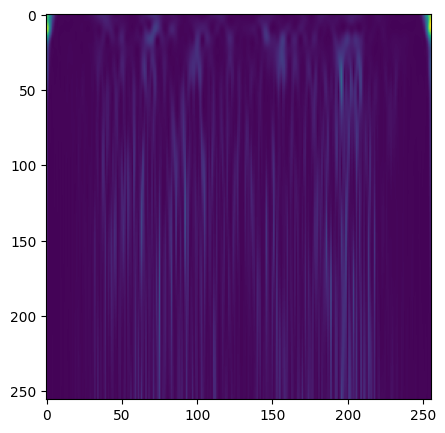

In [16]:
plt.figure(figsize=(5, 5))
plt.imshow(img[:, :, 1].astype(np.float32))
plt.show()

In [58]:
def get_stat(file_path, img_size=(256, 256)):
    x = np.load(file_path)
    x = min_max_scale(x)
    images = []
    for ii in range(3):
        strain = TimeSeries(x[ii, :], t0=0, dt=1 / 2048)

        hq = strain.q_transform(qrange=(4, 32), frange=(20, 400), logf=False, whiten=False, fduration=1, tres=2 / 1000)
        images.append(hq)

    img = np.stack([np.array(x).T[:-200] for x in images], axis=2)
    img = cv2.resize(img, img_size)
    result = {}
    result["max"] = img.max(axis=(0,1))
    result["min"] = img.min(axis=(0,1))
    result["mean"] = img.mean(axis=(0,1))
    result["std"] = img.max(axis=(0,1))

    return result

In [59]:
results = []
for p in tqdm(df.sample(2000, replace=False)['path']):
    r = get_stat(p)
    results.append(r)

100%|██████████| 2000/2000 [05:31<00:00,  6.04it/s]


In [60]:
maxes = np.array([r['max'] for r in results])
mines = np.array([r['min'] for r in results])

In [61]:
maxes.mean(axis=0)

array([4018.0603 , 4225.3594 ,  141.42232], dtype=float32)

In [62]:
maxes.max(axis=0)

array([43362.887 , 53319.57  ,  1203.8624], dtype=float32)

In [63]:
mines.mean(axis=0)

array([-80.708565 , -85.47979  ,  -0.3418851], dtype=float32)

In [64]:
mines.min(axis=0)

array([-1714.5474   , -1357.4182   ,    -4.7959514],
      dtype=float32)

In [51]:
img = np.ones((300, 300, 3))*10
img

array([[[10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        ...,
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.]],

       [[10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        ...,
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.]],

       [[10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        ...,
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.]],

       ...,

       [[10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        ...,
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.]],

       [[10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        ...,
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.]],

       [[10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.],
        ...,
        [10., 10., 10.],
        [10., 10., 10.],
        [10., 10., 10.]]

In [52]:
np.clip(img, [0, 0, 0], [1, 1, 1])

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [57]:
np.load(df.loc[0, "path"]).max()

1.7053709364481296e-20

In [25]:
x = torch.rand(7, 3, 256, 256)
ds_min = torch.tensor([0.3, 0.4, 0.5]).reshape(1, 3, 1, 1)
ds_max = torch.tensor([1.3, 1.4, 1.5]).reshape(1, 3, 1, 1)
x_std = (x - ds_min)/(ds_max - ds_min)
x = x_std*2 - 1

In [27]:
x.shape

torch.Size([7, 3, 256, 256])